# Dopamin modulation of iMSN
run using: 
    
    dopamin_mod_of_iMSN.py 
and 
    
    static_mod.job
    
the save structure is slightly different from the one used in Lindroos et al., 2018:

    RES[random_set_number][solution_number][current_rheobase+/-10pA] = spikes

modulation factors are drawn from random intervals:


In [3]:
import numpy                as np
import matplotlib.pyplot    as plt
import matplotlib.gridspec  as gridspec
from   matplotlib.mlab  import griddata
import pandas               as pd
from pandas.tools.plotting  import table
import glob
import pickle
import sys
import itertools
%matplotlib inline

from scipy.stats import linregress

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams['savefig.dpi'] = 1200

pd.set_option('display.notebook_repr_html', True)

def _repr_latex_(self):
    return "%s" % self.to_latex()

pd.DataFrame._repr_latex_ = _repr_latex_  # monkey patch pandas DataFrame


import warnings; warnings.simplefilter('ignore')

In [1]:
data = [['Naf', 'small decrease (~3.5%)', 'Surmeier et al., 1992', 'dissociated cells'],
        ['Naf', '+ 27.7 +/- 10.9','Hu et al., 2005','NAc'],
        ['Nap','abolished or sign reduced', 'Cepeda et al. 1995', 'DA; no distinction between i/dMSN'],
        ['Kas','Increase 5-10 %','Kitai and Surmeier 1993','no distinction between subtype'],
        ['Kaf','no change','Kitai and Surmeier 1993'],
        ['Kas/Kaf','no change','Altemus and Levine 1996','no distinction between subtype'],
        ['K','Increase','Greif et al., 1995','Quinpirole/DA'],
        ['A-type (K+)','increase (mech inh PKA)','Perez et al 2006','NAc'],
        ['KIR','decrease (PI-PLC)','Perez et al 2006'],
        ['KIR','decrease ~10% (PLC-PKC)','Zhao et al 2016'],
        ['NMDA','decreased Ca influx (50%)','Higley and Sabatini 2010','..but no change epsp? Measured florescent'],
        ['Non-NMDA','no change','Higley and Sabatini 2010'],
        ['Cav2.3 (R )','Down 30%','Higley and Sabatini 2010'],
        ['CaL','Decreased?','Flores-Barrera et al 2011'],
        ['CaL','Down ~25%','Hernandez-Lopez et al 2000'],
        ['Ca','Down ~35% (L>P/Q>N)','Salgado et al 2005'],
        ['Cav2.1 (P/Q)','Down 18+/-2','Salgado et al 2005','PD40; smaller decrease PD14'],
        ['Cav2.2 (N)','Down 3 +/-1','Salgado et al 2005','PD40; larger decrease PD14'],
        ['AMPA','Down 25-30 (27.6+/-6.6)%','Hernandez-Echeagaray et al 2004','more dendrites give larger decrease'],
        ['Ca','Down 25-30%','Hernandez-Echeagaray et al 2004'],
        ['NMDA','Inconsistent 0.6+/-8.3','Levine et al 1996(a and b)'],
        ['Non-NMDA','Down ~20%','Levine et al 1996(a and b)'],
        ['NMDA','Down ~25%','Andre et al 2010','FVB ⁄ N background mice; don’t know this article'],
        ['AMPA','Down ~10%','Andre et al 2010'],
        ['AMPA','Down','Håkansson et al 2006'],
        ['AMPA','phosphorylation not changed','Xue et al 2016','But coadministration with D1 agonist give effect'],
        ['tonic GABA','Down ~60%','Janssen et al 2009'],
        ['Exicitability', 'Decreased', 'janssen et al 2009', 'rheobase increased following quinpirol']]

In [4]:
pd.DataFrame(data, columns=['Channel','Effect','Source','comment']).fillna("")

Channel                       Effect  \
0             Naf       small decrease (~3.5%)   
1             Naf              + 27.7 +/- 10.9   
2             Nap    abolished or sign reduced   
3             Kas              Increase 5-10 %   
4             Kaf                    no change   
5         Kas/Kaf                    no change   
6               K                     Increase   
7     A-type (K+)      increase (mech inh PKA)   
8             KIR            decrease (PI-PLC)   
9             KIR      decrease ~10% (PLC-PKC)   
10           NMDA    decreased Ca influx (50%)   
11       Non-NMDA                    no change   
12    Cav2.3 (R )                     Down 30%   
13            CaL                   Decreased?   
14            CaL                    Down ~25%   
15             Ca          Down ~35% (L>P/Q>N)   
16   Cav2.1 (P/Q)                  Down 18+/-2   
17     Cav2.2 (N)                  Down 3 +/-1   
18           AMPA     Down 25-30 (27.6+/-6.6)%   
19             Ca                  Down 25-30%   
20           NMDA       Inconsistent 0.6+/-8.3   
21       Non-NMDA                    Down ~20%   
22           NMDA                    Down ~25%   
23           AMPA                    Down ~10%   
24           AMPA                         Down   
25           AMPA  phosphorylation not changed   
26     tonic GABA                    Down ~60%   
27  Exicitability                    Decreased   

                             Source  \
0             Surmeier et al., 1992   
1                   Hu et al., 2005   
2                Cepeda et al. 1995   
3           Kitai and Surmeier 1993   
4           Kitai and Surmeier 1993   
5           Altemus and Levine 1996   
6                Greif et al., 1995   
7                  Perez et al 2006   
8                  Perez et al 2006   
9                   Zhao et al 2016   
10         Higley and Sabatini 2010   
11         Higley and Sabatini 2010   
12         Higley and Sabatini 2010   
13        Flores-Barrera et al 2011   
14       Hernandez-Lopez et al 2000   
15               Salgado et al 2005   
16               Salgado et al 2005   
17               Salgado et al 2005   
18  Hernandez-Echeagaray et al 2004   
19  Hernandez-Echeagaray et al 2004   
20       Levine et al 1996(a and b)   
21       Levine et al 1996(a and b)   
22                 Andre et al 2010   
23                 Andre et al 2010   
24             Håkansson et al 2006   
25                   Xue et al 2016   
26               Janssen et al 2009   
27               janssen et al 2009   

                                             comment  
0                                  dissociated cells  
1                                                NAc  
2                  DA; no distinction between i/dMSN  
3                     no distinction between subtype  
4                                                     
5                     no distinction between subtype  
6                                      Quinpirole/DA  
7                                                NAc  
8                                                     
9                                                     
10         ..but no change epsp? Measured florescent  
11                                                    
12                                                    
13                                                    
14                                                    
15                                                    
16                       PD40; smaller decrease PD14  
17                        PD40; larger decrease PD14  
18               more dendrites give larger decrease  
19                                                    
20                                                    
21                                                    
22  FVB ⁄ N background mice; don’t know this article  
23                                                    
24                                                  

In [5]:
summary =[['Naf','Down 5 → up 30', '0.9-1.3', 'But according to review by Do et al 2013 reduced → check sources'],
          ['Nap','Down', '-','But no distinction between i/dMSN → add nap?'],
          ['Kas','no change – up 10', '1.0-1.2'],
          ['Kaf','no change – increase', '0.95-1.1'],
          ['Kir','decrease', '0.7-1.0', 'slightly increase lower limit?'],
          ['CaL','Down 25', '0.7-0.8'],
          ['Cap,q','Down 20', '-','add CaP,Q'],
          ['CaN','Down 3', '0.95-1.5', 'larger in younger animals'],
          ['CaR','Down 30', '0.65-0.75'],
          ['NMDA','Down 25 – small increase'],
          ['AMPA','Down30 – no change'],
          ['GABA','?']]
pd.DataFrame(summary, columns=['Channel','Effect', 'in sim', 'comment']).fillna("")

Channel                    Effect     in sim  \
0      Naf            Down 5 → up 30    0.9-1.3   
1      Nap                      Down          -   
2      Kas         no change – up 10    1.0-1.2   
3      Kaf      no change – increase   0.95-1.1   
4      Kir                  decrease    0.7-1.0   
5      CaL                   Down 25    0.7-0.8   
6    Cap,q                   Down 20          -   
7      CaN                    Down 3   0.95-1.5   
8      CaR                   Down 30  0.65-0.75   
9     NMDA  Down 25 – small increase              
10    AMPA        Down30 – no change              
11    GABA                         ?              

                                              comment  
0   But according to review by Do et al 2013 reduc...  
1        But no distinction between i/dMSN → add nap?  
2                                                      
3                                                      
4                      slightly increase lower limit?  
5                                                      
6                                           add CaP,Q  
7                           larger in younger animals  
8                                                      
9                                                      
10                                                     
11

### Functions

In [9]:
def load_obj(name ):
    with open(name, 'rb') as f:
        return pickle.load(f) 
    
def save_obj(obj, name ):
    '''
    functions used to save data in the pickle format. 
    Used to pickle dictionaries
    
    obj     = dictionary with data
    name    = name to be used, without file ending (.pkl will be added)
    '''
    
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        


def pie_autopct(pct):
    #print pct
    return ('%1.0f' % pct) if pct > 20 else ''



def plot_pie(N, autopct, color=None, ax=False, shadow=False):
    
    if not ax:
        fig, ax = plt.subplots(1,1,figsize=(4,3))
    
    if color:
        ax.pie(N, colors=color,
            autopct=autopct, shadow=False)
    else:
        ax.pie(N, autopct=autopct, shadow=False)
    
    ax.axis('equal')
    
    #plt.rcParams['font.size'] = 50
    
    

def plot_fig4_raster(file_string, plotLength=100, N=2500):
    
    quant = {0:0, 1:0, 2:0}
    
    # raster plot-------------------------------------------------------------------------
    f, a  = plt.subplots(3, 1, figsize=(4,3))
    
    # load 30 best solutions (used for extracting rheobase of all solution)
    best30 = load_obj('D2_30bestFit.pkl')
    
    # load files
    files   = glob.glob(file_string)
    counter = 0
    
    # draw plotLength random spike trains to plot (from the N first traces)
    trains2plot = np.random.choice(N, plotLength, replace=False)
    
    for f in files:
        
        spike_dict = load_obj(f)
        
        # loop over random modulation sets
        for i in spike_dict:
            
            # loop over model soultions
            for m in spike_dict[i]:
                
                if m in ['factors']:
                    continue
                
                counter += 1
                
                # loop over current injections (rheobase +/- 10 pA)
                for c in sorted(spike_dict[i][m]):
                        
                    # get current magnitude of solution--not used
                    rheobase = best30[m]['rheobase']
                    current  = rheobase + (c-1)*10

                    # do something with the data
                    spikes = spike_dict[i][m][c]
                    
                    # quantify; if spikes or last injection -> increase count
                    if len(spike_dict[i][m][c]) > 0 or c == 2:
                        
                        quant[c] += 1
                        
                        if counter in trains2plot:
                        
                            # get index in trains2plot
                            index = np.where(trains2plot==counter)[0]
                            
                            # create y vector (filled with counter -1)
                            y = np.ones( len(spike_dict[i][m][c]) ) + index - 1

                            if len(spike_dict[i][m][c]) > 0:
                                a[c].plot(spike_dict[i][m][c], y, 'k|', mew=2, ms=3, alpha=1.0)
                                
                        break
                    
    
    print 'number of soulutions\t', counter
    print 'more:',quant[0], '\tequal:', quant[1], '\tless:', quant[2]
    
    for i in range(3):
                
        ylimits = [-0.5, plotLength-0.5]
        a[i].set_ylim(ylimits)
        a[i].set_yticks([])
        a[i].set_ylabel(str((i-1)*10), fontsize=18)
        a[i].spines['left'].set_linewidth(2)
        a[i].set_xlim([0,1000])
        
        if not i == 2:
            a[i].set_xticks([])
            
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom='off',      # ticks along the bottom edge are off
                top='off',         # ticks along the top edge are off
                labelbottom='off') # labels along the bottom edge are off
            
    
    
    xticks = [0,500,1000]
    a[-1].xaxis.set_ticks(xticks)
    a[-1].set_xticklabels(xticks, fontsize=18)
    a[-1].spines['bottom'].set_visible(True)        
    a[-1].xaxis.set_ticks_position('bottom')
    a[-1].spines['bottom'].set_linewidth(2)
    a[0].spines['top'].set_linewidth(1)
    a[-1].set_xlabel("Time (ms)", fontsize=20)
    
    
    
    # pie plot ---------------------------------------------------------------------------
    
    N       = [ quant[0],  quant[1],  quant[2] ]
    colors   = ['r', 'grey', 'b']
    
    plot_pie(N, 
            autopct=pie_autopct, color=colors, shadow=False)
    
    plt.show()
    
    
    
def hinton(matrix, max_weight=None, ax=None, col=None, row=None, reverse_color=False):
    """Draw Hinton diagram for visualizing a weight matrix.
    from:
    http://python-for-multivariate-analysis.readthedocs.io/a_little_book_of_python_for_multivariate_analysis.html
    """
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

    ax.patch.set_facecolor('lightgray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    if col and row:
        
        w       = matrix[col][row]
        color   = 'orange' if w > 0 else 'black'
        if reverse_color:
            color   = 'black' if w > 0 else 'orange' 
        print w, color
        size    = np.sqrt(np.abs(w))
        rect    = plt.Rectangle([0.5 - size / 2, 0.5 - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
        ax.add_patch(rect)
        
    else:
        for (x, y), w in np.ndenumerate(matrix):
            color   = 'orange' if w > 0 else 'black'
            size = np.sqrt(np.abs(w))
            rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
            ax.add_patch(rect)
    
    
        nticks = matrix.shape[0]
        #ax.xaxis.tick_top()
        ax.set_xticks(range(nticks))
        ax.set_xticklabels(list(matrix.columns), rotation=45, fontsize=30)
        ax.set_yticks(range(nticks))
        ax.set_yticklabels(matrix.columns, fontsize=30)
        ax.grid(False)

        ax.autoscale_view()
        ax.invert_yaxis()

        
def check_range(slice_i, channels, Filter):
    # check factor range. if at least one factors is outside range
    #     return True
    # else
    #     return False
    
    for chan in Filter:
        
        # get index
        index   = channels.index(chan)
        factor  = slice_i['factors'][index]
        
        # get ref range
        ref     = Filter[chan]
        
        # compare
        if np.abs(factor-ref[0]) > ref[1]:
            return True
        
    return False
    
    
        
        
def create_data_frame(fstring, channels=None, N=40000, Filter=False):
    
    if not channels:
        channels = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can', 'car']
    M        = len(channels)+2
    
    # initiate array
    A        = np.zeros((N,M))
    
    files    = glob.glob(fstring)
    count    = 0
    for f in files:
        # load pickle        
        data  = load_obj( f )
        
        # loop over random sets
        for i in data:
            
            if Filter:
                # check solutions ***********************************************
                if check_range(data[i], channels, Filter):
                    continue
            
            # loop over model cell version (iMSN)
            for m in data[i]:
                
                if m in ['factors']:
                    continue
                
                # compare excitability by looping over current injections (rheobase +/- 10 pA)
                for c in range(3):

                    # quantify; if spikes or last injection -> store current number 0/1/2
                    if len(data[i][m][c]) > 0 or c == 2:
                        
                        A[count,0] = c
                        break
                
                # save model version
                A[count,M-1] = m
                
                # save modulation factor
                A[count,1:1+len(channels)] = np.multiply(data[i]['factors'],100)
                
                # increase count
                count += 1
    
    print count
    
    # returned data frame created from array (cropped at count)
    return pd.DataFrame(A[0:count], columns=['group']+channels+['models'])
        

    

def run_correlation_analysis(df, channels, marker='test'):
    '''
    data_frame = pandas data frame
    channels   = modulated channels
    marker     = ?
    '''
    
    colors = ['b', 'grey', 'r']
    alpha  = [0.004, 0.04, 0.005]    # used for setting alpha of scatter plots
    
    #df.boxplot(by='group')
    
    f_corr, a_corr = plt.subplots(1,3)
    f_sc,   a_sc   = plt.subplots(2,3, sharey=True, sharex=True)
    f_sc3d, a_sc3d = plt.subplots(1,3, sharey=True)
    
    f_sc.subplots_adjust(wspace=0.5) #hspace=0.5,
    #f_sc3d.subplots_adjust(wspace=0.5)
    
    fig  = plt.figure()
    gs   = gridspec.GridSpec(2, len(channels), height_ratios=[4, 1], hspace = .6)
    ax1  = plt.subplot(gs[0, :])
    axes = []
    fs   = 14
    fs2  = 20
    
    for i in range(len(channels)):
        axes.append( plt.subplot(gs[1, i]) )
    
    ax1.plot([-1,31], [100, 100], '--k', lw=3)
    
    # loop over groups
    for g,group in enumerate([2.0, 1.0, 0.0]):
        
        # correlation between first four channels in list
        df1 = df.loc[df['group'] == group, channels[0:4]]
        
        corrmat = df1.corr() #method='spearman')
        hinton(corrmat, ax=a_corr[g])
        
        if g > 0:
            a_corr[g].set_yticks([])
        
        # get channel modulation factors for specific group
        kaf = df.loc[df['group'] == group, 'kaf']
        naf = df.loc[df['group'] == group, 'naf']
        kir = df.loc[df['group'] == group, 'kir']
        kas = df.loc[df['group'] == group, 'kas']
        
        chan_2b_paired = [naf, kir]
        
        position    = []
        mean        = []
        for i in range(len(channels)):
            mean.append([])
        
        a_sc3d[g].plot([0,200], [100,100], 'k')
        a_sc3d[g].plot([100,100], [0,200], 'k')
        sc = a_sc3d[g].scatter(kaf, naf, c=kir, cmap='copper', s=kas, lw=0.5, edgecolor='g', alpha=1)
    
        if g == 2:
            # colorbar
            fc,ac = plt.subplots()
            cbar  = fc.colorbar(sc, ticks=[0, 100, 200], orientation='horizontal')
            cbar.ax.set_xticklabels([0, 100, 200], fontsize=fs)
            ac.remove()
        a_sc3d[g].set_xticks([0,100,200])
        a_sc3d[g].set_yticks([0,100,200])
        a_sc3d[g].set_xlim([0,200])
        a_sc3d[g].set_ylim([0,200])
        a_sc3d[g].set(adjustable='box-forced', aspect='equal')
        a_sc3d[g].set_xticklabels([0,100,200], fontsize=fs)
        a_sc3d[g].set_yticklabels([0,100,200], fontsize=fs)
        
        # pick specific channel with value g
        for c,channel in enumerate(channels):
            
            if channel in ['naf','kir']:
                
                a       = ['naf','kir'].index(channel)
                chan    = chan_2b_paired[a]
                
                a_sc[a,g].plot([0,200], [100,100], 'k')
                a_sc[a,g].plot([100,100], [0,200], 'k')
                a_sc[a,g].plot(kaf, chan, 'o', \
                                        ms=8, 
                                        color=colors[g], 
                                        alpha=alpha[g])
                a_sc[a,g].set_xticks([0,100,200])
                a_sc[a,g].set_yticks([0,100,200])
                a_sc[a,g].set(adjustable='box-forced', aspect='equal')
                a_sc[a,g].set_xticklabels([0,100,200], fontsize=fs2)
                a_sc[a,g].set_yticklabels([0,100,200], fontsize=fs2)                
            
            # add channel with specific group to list
            df1 = df.loc[df['group'] == group, channel]
            mean[c].append(df1)
            
            # append position
            position.append( g+c*4 )
        
        # plot
        lw=3
        boxprops    = dict(linewidth=lw, color=colors[g])
        medianprops = dict(linestyle='-', linewidth=lw, color=colors[g])
        
        ax1.boxplot(    mean,                   \
                        positions=position,     \
                        boxprops=boxprops,      \
                        medianprops=medianprops )
    
    ax1.set_xlim([-1,31])
    ax1.set_xticks(np.arange(1,31,4))
    ax1.set_yticks([0,100,200])
    ax1.set_xticklabels(channels, fontsize=fs2, rotation=45)
    ax1.set_yticklabels([0,100,200], fontsize=fs2)
        
    
    # calc and plot correlation between channels and excitability
    corrmat = df.corr()
    
    print corrmat['group']
    
    for i in range( len(axes) ):
        hinton(corrmat, ax=axes[i], col='group', row=i+1, reverse_color=True)
    
    # scatter plot kaf vs naf or kir
    
    '''
    fig.savefig(''.join(['../../../Dropbox/manuscript/Frontiers/Figures/static_', marker, '_chan-exc-cor_pdc.png']), 
               bbox_inches='tight', 
               transparent=True)
               
    f_corr.savefig(''.join(['../../../Dropbox/manuscript/Frontiers/Figures/static_', marker, '_chan-cor_pdc.png']), 
               bbox_inches='tight', 
               transparent=True)
               
    f_sc.savefig(''.join(['../../../Dropbox/manuscript/Frontiers/Figures/static_', marker, '_scatter_pdc.png']), 
               bbox_inches='tight')
    
    f_sc3d.savefig(''.join(['../../../Dropbox/manuscript/Frontiers/Figures/static_', marker, '_scatter3d_pdc.png']), 
               bbox_inches='tight')
    
    #uncomment to save colorbar          
    fc.savefig(''.join(['../../../Dropbox/manuscript/Frontiers/Figures/static_', marker, '_scatter_colorbar.png']), 
               bbox_inches='tight')
    
              
    plt.close('all')'''
    plt.show()
    

    
def filter_and_pie(fstring, Filter, channels,  N=None, ax=None):
    
    data_frame = create_data_frame(fstring, \
                                   Filter=Filter, \
                                   channels=channels)

    # get data
    more = data_frame.loc[data_frame['group'] == 0.0]['group'].tolist()
    eqal = data_frame.loc[data_frame['group'] == 1.0]['group'].tolist()
    less = data_frame.loc[data_frame['group'] == 2.0]['group'].tolist()

    plot_pie([len(less), len(eqal), len(more)],  
                pie_autopct, 
                color=['b','grey','r'],
                ax=ax,
                shadow=False)
    
    L = data_frame['group'].value_counts().sort_index().tolist()
    xl = ''
    xlabel = [xl + str(l)+' ' for l in L]
    
    if ax:
        ax.set_xlabel(xlabel, fontsize=14)
    else:
        plt.xlabel(xlabel, fontsize=14)
    
    if Filter and not ax:
        plt.title(list(Filter)[0])
        plt.show()
    
    



## Simulation results
Simulations run with script dopamine_mod_of_iMSN.py.


### All compartments modulated, without kaf mod

In [10]:
channels   = ['naf', 'kas', 'kaf', 'kir', 'cal12', 'cal13', 'can', 'car']

7906


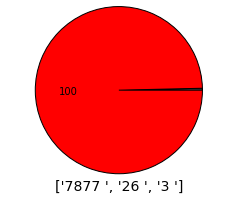

In [11]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-D2-AIS1-KAF0_naf*', \
               Filter=False, \
               channels=channels)

### + Kaf mod

7841


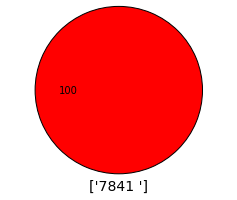

In [12]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-D2-AIS1-KAF1_naf*', \
               Filter=False, \
               channels=channels)

### No mod of AIS (without kaf mod)

7931


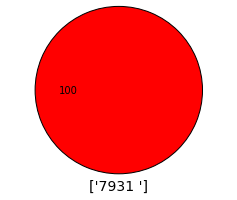

In [13]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-D2-AIS0-KAF0_naf*', \
               Filter=False, \
               channels=channels)

### No modulation of AIS (+ kaf mod)

7931


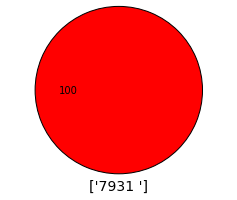

In [14]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-D2-AIS0-KAF1_naf*', \
               Filter=False, \
               channels=channels)

### comments on simlations above
None of the setups above give less excitable cells--more or less all random sets in all model versions are more excitable. 


## Large range
Below the ranges are relaxed to +/- 90%.

### All compartments modulated

39635


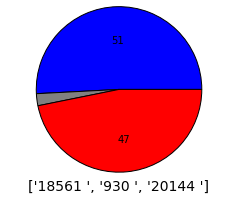

In [15]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-LD2_naf*', \
               Filter=False, \
               channels=channels)

### without AIS modulation
also example of old function for plotting (Lindroos et al., 2018 style). Both give same results.

number of soulutions	39605
more: 20781 	equal: 1192 	less: 17632


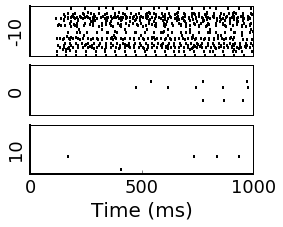

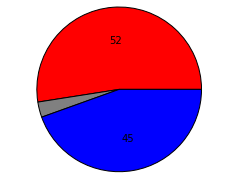

In [16]:
plot_fig4_raster('Results/DA_mod_iMSN/staticMod-noAxon-L-D2_naf*', N=39605)

39605


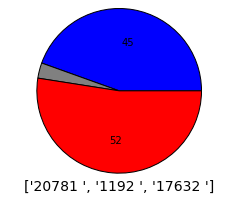

In [17]:
filter_and_pie('Results/DA_mod_iMSN/staticMod-noAxon-L-D2_naf*', \
               Filter=False, \
               channels=channels)

In [18]:
%%latex
\newpage

<IPython.core.display.Latex object>

## Channel influence on excitbaility
**similar to fig 3 in Lindroos et al 2018**

In [19]:
data_frame = create_data_frame('Results/DA_mod_iMSN/staticMod-LD2_naf*', channels=channels)

39635


group     1.000000
naf      -0.607328
kas       0.092104
kaf       0.390051
kir       0.273391
cal12     0.028970
cal13    -0.071297
can       0.019255
car       0.011546
models    0.010555
Name: group, dtype: float64
-0.6073282269766982 orange
0.09210415410072648 black
0.39005076195186 black
0.2733907142235717 black
0.028970445913663496 black
-0.07129668276230883 orange
0.019254614836451606 black
0.011545965178037246 black


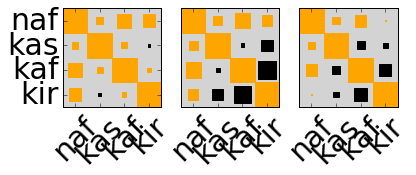

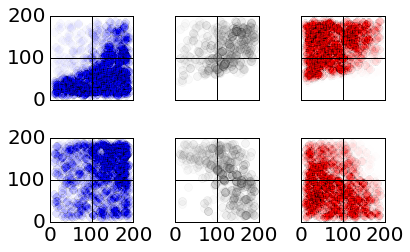

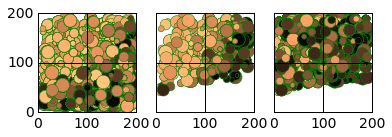

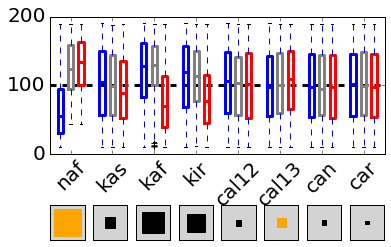

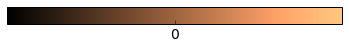

In [20]:
run_correlation_analysis(data_frame, channels=channels)

In [21]:
%%latex
\newpage

<IPython.core.display.Latex object>

39605
group     1.000000
naf      -0.341693
kas       0.123380
kaf       0.577578
kir       0.349720
cal12    -0.038531
cal13    -0.012541
can      -0.021370
car       0.060144
models    0.010769
Name: group, dtype: float64
-0.34169304165454134 orange
0.12338000473393546 black
0.5775778276007981 black
0.3497201468081138 black
-0.03853126389034317 orange
-0.012541427757764845 orange
-0.02136975127753314 orange
0.06014424851778091 black


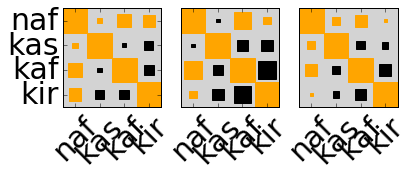

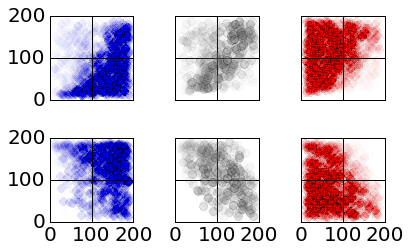

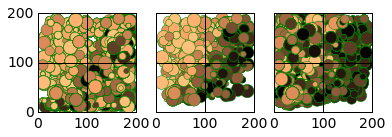

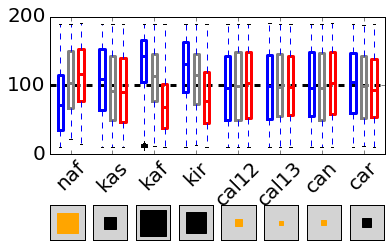

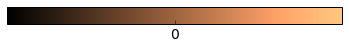

In [22]:
data_frame = create_data_frame('Results/DA_mod_iMSN/staticMod-noAxon-L-D2_naf*', channels=channels)
run_correlation_analysis(data_frame, channels=channels)

## comments on the correlation
The behaviour is close to the fig. 3 in Lindroos et al., (2018). <br>
The Ca channels seems to be a little more influential in general. Not sure if this is due to low sample size or some  other difference between the models (morphological etc).

## Filter large range sample set
The range of the **small** set is 0-40% down and upp for sodium and potassium channels, respectively. <br>
While the same numbers for the **large** set is 0-90% 

In [23]:
%%latex
\newpage

<IPython.core.display.Latex object>

8422
8541
8969
9547
19310
18876
20430
20407


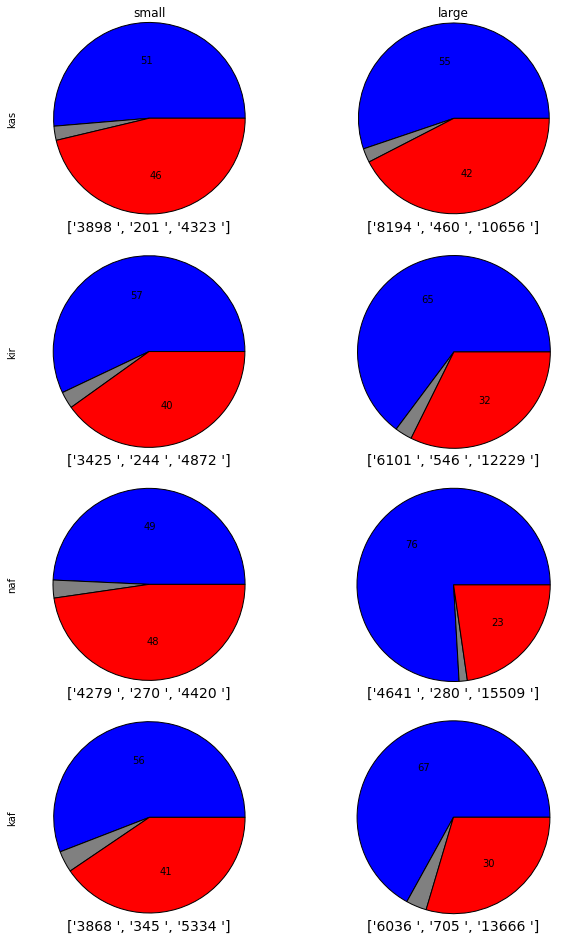

In [24]:
MASTER_FILTER = {'small': {'naf':[0.8, 0.2], 'kaf':[1.2,0.2], 'kir':[1.2,0.2], 'kas':[1.2,0.2]},
                 'large': {'naf':[0.5, 0.5], 'kaf':[1.5,0.5], 'kir':[1.5,0.5], 'kas':[1.5,0.5]}
                }

fig, ax = plt.subplots( len(MASTER_FILTER['small'] ), 
                        len(MASTER_FILTER),
                        figsize=(10,16) )

for s, size in enumerate(MASTER_FILTER):
    
    ax[0,s].set_title(size)
    
    for c, chan in enumerate(MASTER_FILTER[size]):
        
        filter_and_pie('Results/DA_mod_iMSN/staticMod-LD2_naf*', \
               Filter={chan:MASTER_FILTER[size][chan]}, \
               ax=ax[c,s], \
               channels=channels)
        
        if s == 0:
            ax[c,0].set_ylabel(chan)

plt.show()

In [25]:
%%latex
\newpage

<IPython.core.display.Latex object>

8518
8810
9687
8634
19721
20372
20757
19791


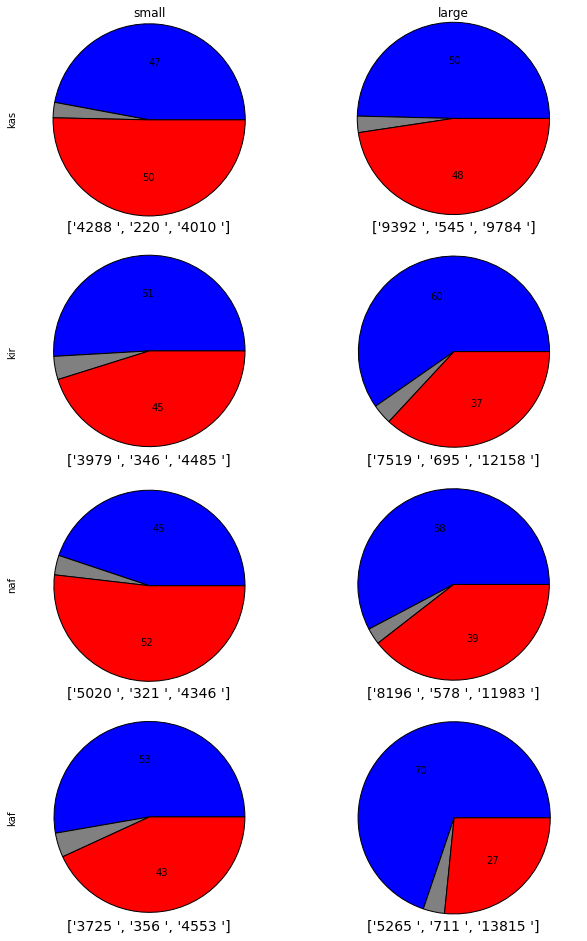

In [26]:
fig, ax = plt.subplots( len(MASTER_FILTER['small'] ), 
                        len(MASTER_FILTER),
                        figsize=(10,16) )

for s, size in enumerate(MASTER_FILTER):
    
    ax[0,s].set_title(size)
    
    for c, chan in enumerate(MASTER_FILTER[size]):
        
        filter_and_pie('Results/DA_mod_iMSN/staticMod-noAxon-L-D2_naf*', \
               Filter={chan:MASTER_FILTER[size][chan]}, \
               ax=ax[c,s], \
               channels=channels)
        
        if s == 0:
            ax[c,0].set_ylabel(chan)

plt.show()

## No model version seems more likely to decrease excitability

Counts are normalized to average model version size.

### All compartments modulated

39635


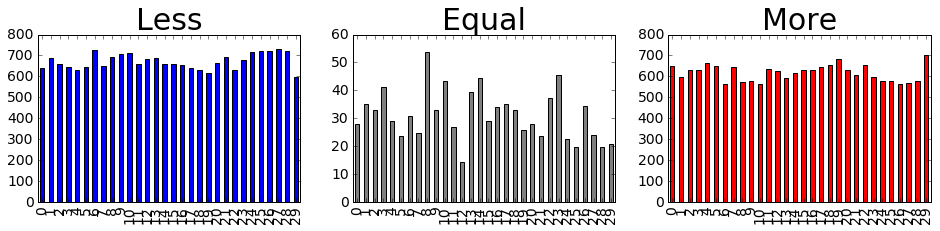

In [27]:
# IMPORTANT! 
# The count returned by value_counts needs to be resorted based on model number (index). 
# Running value_counts(sort=False) can not be used since it seems to return random ordered  
#        counts ("for key in dict" style).
#
# Values are normalized to average model version size (norm = TOTALm / AVERAGE)


# create frame
df = create_data_frame('Results/DA_mod_iMSN/staticMod-LD2_naf*', channels=channels)

# create norm vector: norm=total/average; average=sum(total)/30

total   = df['models'].value_counts().sort_index().tolist()

average = np.sum(total)/30.0
norm    = np.divide(total, average)

fig, ax = plt.subplots(1,3, figsize=(16,3))
label   = ['Less', 'Equal', 'More']
color   = ['b','grey','r']

# loop over groups
for g,group in enumerate([2.0, 1.0, 0.0]):
    
    # select right excitability type
    df1 = df.loc[ df['group'] == group ]
    
    # count model versions in group; sort=False
    L   = np.divide(df1['models'].value_counts().sort_index().tolist(), norm)
    
    #plt.figure()
    #series = pd.Series(L, index=np.arange(0,30), name=labels[g])
    #ax     = series.plot.pie(figsize=(12, 12),   fontsize=20)
    
    
    df2 = pd.DataFrame(L)
    df2.plot.bar(legend=False, fontsize=14, color=color[g], ax=ax[g])
    ax[g].set_title(label[g], fontsize=30)

plt.show()

### Axon not modulated

39605


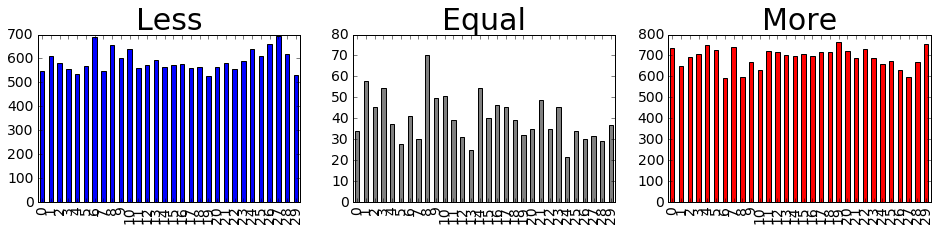

In [28]:
# create frame
df = create_data_frame('Results/DA_mod_iMSN/staticMod-noAxon-L-D2_naf*', channels=channels)

# create norm vector: norm=total/average; average=sum(total)/30

total   = df['models'].value_counts().sort_index().tolist()

average = np.sum(total)/30.0
norm    = np.divide(total, average)

fig, ax = plt.subplots(1,3, figsize=(16,3))
label   = ['Less', 'Equal', 'More']
color   = ['b','grey','r']

# loop over groups
for g,group in enumerate([2.0, 1.0, 0.0]):
    
    # select right excitability type
    df1 = df.loc[ df['group'] == group ]
    
    # count model versions in group; sort=False
    L   = np.divide(df1['models'].value_counts().sort_index().tolist(), norm)
    
    #plt.figure()
    #series = pd.Series(L, index=np.arange(0,30), name=labels[g])
    #ax     = series.plot.pie(figsize=(12, 12),   fontsize=20)
    
    
    df2 = pd.DataFrame(L)
    df2.plot.bar(legend=False, fontsize=14, color=color[g], ax=ax[g])
    ax[g].set_title(label[g], fontsize=30)

plt.show()

### Comment
Seems like the subtle trends over model versions are the same with and without modulation of AIS. <br>
Perhaps there's some correlation to be fund here (excitability, channel conductance etc).


## How about correlation with rheobase?

Add as a column to frame and check correlation with different excitability groups. <br> 
TODO
